In [3]:
import pipeline
import pandas as pd
import numpy as np
import importlib
importlib.reload(pipeline)

<module 'pipeline' from 'C:\\Google Drive\\Machine Learning\\ml-covid\\scripts\\pipeline.py'>

In [4]:
filepath = '../data/covid_df_protocol_3.pkl'
df = pd.read_pickle(filepath)
df['log_cases'] = np.log(df['Confirmed Cases'] + 1)

In [6]:
#filepath = '../data/covid_df_protocol_3.pkl'
weeks_for_cv = [0,1,2,3,4,5,6]
#df = pd.read_pickle(filepath)
n_weeks_prediction = 2
results = {}
for i in weeks_for_cv:
    shorter_df = pipeline.cut_df_on_weeks(df, i)
    df_train, df_test = pipeline.split_and_scale_on_last_weeks(shorter_df, n_weeks_prediction)
    pipeline.sanity_check(df_train, df_test)
    #df_train = df_train.dropna()
    #df_test = df_test.dropna()
    X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
    X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
    dct = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)
    results['Until week: ' +str(i)] = dct

Cutting dataframe on date: 2020-06-02
Success: Features match
Success: No NAs remain
Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     2.485656
8             EconomicSupportIndex     0.170124
19   Days Elapsed Since First Case     0.065121
18                       Day Count     0.003454
149            Country_Switzerland     0.000000
139              Country_Singapore    -0.000000
140        Country_Slovak Republic     0.000000
141               Country_Slovenia     0.000000
142           Country_South Africa     0.000000
143            Country_South Korea     0.000000

Bias: 3.24
Mean squared error: 4.33
RSS: 6584.70
Variance score: 0.76

R2 score: 0.35

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     7.789003
110       Country

Success: Features match
Success: No NAs remain
Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     2.143230
8             EconomicSupportIndex     0.347468
19   Days Elapsed Since First Case     0.056539
18                       Day Count     0.007406
5                  StringencyIndex     0.001210
150                 Country_Sweden    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000

Bias: 2.81
Mean squared error: 3.99
RSS: 8374.24
Variance score: 0.71

R2 score: 0.46

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept     8.795956
85                  Country_Iran     2.0288

In [3]:
df.columns

Index(['Country', 'Date', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'StringencyIndex', 'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Confirmed Cases', 'Recovered', 'Deaths', 'GDP',
       'Population', 'Share Pop 65+', 'Hospital Beds per 1k',
       'Life Expectancy', 'Physicians per 1k',
       'Universal Health Care Coverage Index', 'Diabetes Prevalence',
       'Current Health Expenditure Per Capita, PPP', 'Day Count',
       'Days Elapsed Since

In [61]:
from sklearn import linear_model
import numpy as np
n_weeks_prediction = 2
df['log_cases'] = np.log(df['Confirmed Cases'] + 1)
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df_spain, n_weeks_prediction)
X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)

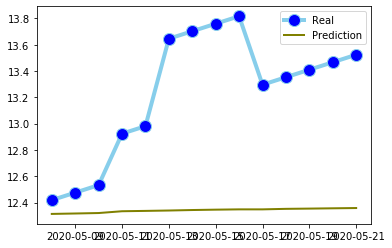

In [62]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'Spain')

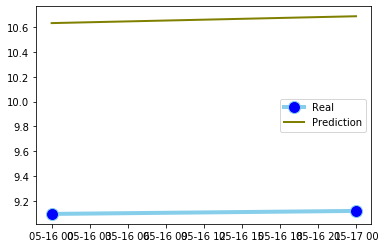

In [9]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'Chile')

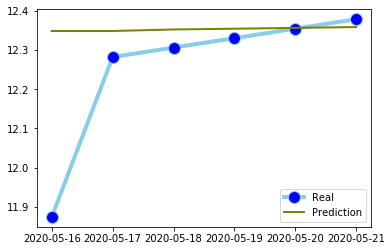

In [10]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'Spain')

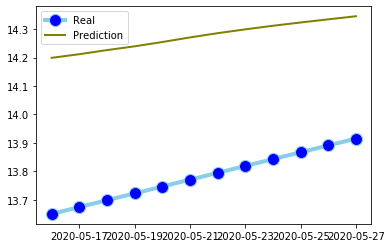

In [11]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'United States of America')

In [28]:
predictions = pipeline.predictions_every_country(X_test.columns[19:164], X_test, y_pred, y_test)
#predictions = pipeline.predictions_every_country([X_test.columns[19]], X_test, y_pred, y_test)

KeyError: 'Country_United States of America'

In [29]:
spain = pd.DataFrame()
spain['Spain real'] = y_test
spain['Spain pred'] = y_pred
spain['date'] = predictions.index

In [32]:
spain = spain.set_index('date')
spain

,Spain real,Spain pred
date,,
2020-05-16,12.314290,1.244043e+01
2020-05-17,12.317520,1.248535e+01
2020-05-18,12.320967,1.252344e+01
2020-05-19,12.334629,-2.720269e+07
2020-05-20,12.337237,-2.720269e+07
2020-05-21,12.340131,-3.745883e+07
2020-05-22,12.343837,-3.745883e+07
2020-05-23,12.346634,-3.745883e+07
2020-05-24,12.348869,-3.745883e+07


In [14]:
predictions.head()

,Afghanistan real,Afghanistan prediction,Albania real,Albania prediction,Algeria real,Algeria prediction,Angola real,Angola prediction,Argentina real,Argentina prediction,...,Venezuela real,Venezuela prediction,Vietnam real,Vietnam prediction,Yemen real,Yemen prediction,Zambia real,Zambia prediction,Zimbabwe real,Zimbabwe prediction
date,,,,,,,,,,,,,,,,,,,,,
2020-05-16,8.764522,6.850647,6.839476,8.422456,8.827908,8.901507,3.891820,5.689538,8.962648,7.694289,...,6.224558,7.093339,5.765191,5.880071,4.812184,3.280651,6.522093,4.788202,3.761200,5.219018
2020-05-17,8.804625,6.874754,6.853299,8.446563,8.856518,8.925614,3.891820,5.754294,8.995785,7.718397,...,NaN,NaN,5.771441,5.904178,4.859812,3.304758,6.625392,4.812309,3.806662,5.243126
2020-05-18,8.864040,6.898861,6.855409,8.850055,8.882114,8.949721,3.931826,5.778401,9.032648,7.742504,...,NaN,NaN,5.783825,5.928285,4.875197,3.328866,6.635947,4.836416,3.850148,5.267233
2020-05-19,8.942984,6.922969,6.856462,8.874163,8.906258,8.973829,3.970292,5.802508,9.083643,7.766611,...,NaN,NaN,5.783825,5.952392,5.123964,3.352973,6.650279,4.860524,3.850148,5.291340
2020-05-20,9.005282,6.947076,6.872128,8.898270,8.928375,8.997936,3.970292,5.826616,9.136048,7.790718,...,NaN,NaN,5.783825,5.976500,5.220356,3.377080,6.725034,4.884631,3.891820,5.315447


In [15]:
pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     2.404227
8             EconomicSupportIndex     0.191144
19   Days Elapsed Since First Case     0.064166
18                       Day Count     0.005049
145            Country_Switzerland     0.000000
135              Country_Singapore    -0.000000
136        Country_Slovak Republic     0.000000
137               Country_Slovenia     0.000000
138           Country_South Africa     0.000000
139            Country_South Korea     0.000000

Bias: 3.22
Mean squared error: 4.09
RSS: 6070.68
Variance score: 0.75

R2 score: 0.41

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     9.725986
110          Country_Nepal    -3.103819
161        Country_Vietnam    -2.754382
106       Country_Mong

{'Lasso': (3.2236579693305067,
  4.085250674275898,
  6070.6825019739845,
  0.7541839491960279,
  0.4058991396170867),
 'Ridge': (1.2301038523835528,
  1.949422790037692,
  2896.84226599601,
  0.9061999523682485,
  0.7165036250763896),
 'Linear Regression': (1.2284795630016718,
  1.9350478092212535,
  2875.481044502783,
  0.9063238105458267,
  0.7185941182069115)}

In [20]:
predictions.to_pickle("../data/predictions.pkl")

In [36]:
spain.to_pickle("../data/predictions_log_spain.pkl")